# Sequential Input을 활용한 모델

sequential input을 활용한 supervised model 기본 튜토리얼입니다.

neural network와 LSTM, Transformer를 포함한 공통 아키텍처를 주로 배웁니다.

## Data
노트북은 데이터셋을 직접 만들어서 사용하며, 외부 라이브러리가 불필요합니다.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense, Input, LSTM, Dot, Concatenate
from tensorflow.keras.layers import Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from tensorflow.keras import backend as K
import tensorflow_probability as tfp

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import rc, cm
plt.rcParams.update({'pdf.fonttype': 'truetype'})

# Sequence 생성

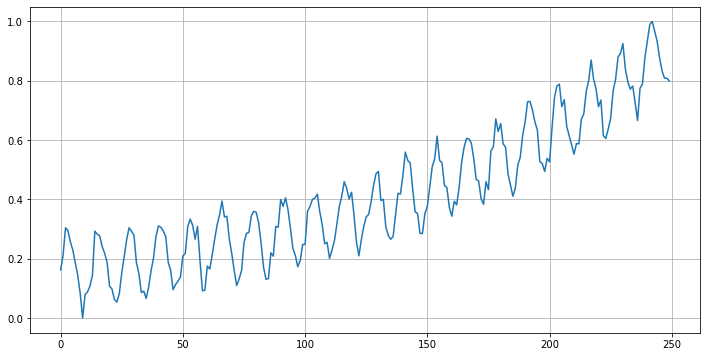

In [2]:
#
# trend와 seasonality가 존재한 timeseries 데이터를 만듭니다
#
n_time_steps = 250
index = np.arange(n_time_steps)
s = np.sin(index / 2) + np.exp(index / n_time_steps * 2.0 )
s += np.random.normal(0, 0.2, n_time_steps)
scaler = MinMaxScaler(feature_range=(0, 1))
s = scaler.fit_transform(s.reshape(-1, 1))[:, 0]
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(s)
ax.grid(True)

# 데이터 준비 & 시각화 함수

In [3]:
#
# sample로 사용하기 위해 Reshape
# (x_{t-n_lags}, ..., x_t) -> (x_{t+1})
# s - input 1D time series
#
def series_to_dataset(s, input_width, label_offset, label_width):
    x, y = [], []
    
    for i in range(len(s) - input_width - label_width - label_offset):
        w = s[i : (i + input_width)]
        x.append(w)
        # i + input sequence 길이 + data와 label 간 거리
        y.append(s[i + input_width + label_offset : i + input_width + label_offset + label_width])
        
    return np.array(x), np.array(y)

#
# train/test dataset 생성
# X: 3D tensor with shape [number of samples, window width, number of features]
# Y: 2D tensor with shape [number of samples, label width] 
#
def create_dataset(s, train_test_ratio, input_width, label_offset = 0, label_width = 1): 
    #
    # Split the series into train and test datasets
    #
    train_size = int(len(s) * train_test_ratio)
    test_size = len(s) - train_size
    train, test = s[:train_size], s[train_size:]
    print(f'Train set: {len(train)} samples, test set: {len(test)} samples')
    
    x_train, y_train = series_to_dataset(train, input_width, label_offset, label_width)
    x_test, y_test = series_to_dataset(test, input_width, label_offset, label_width)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return (x_train, y_train), (x_test, y_test)

#
# Plot the results
#
def plot_forecast(index, s, input_width, label_offset, y_train_pred, y_test_pred):
    label_width = y_train_pred.shape[1]
    fig, ax = plt.subplots(1, figsize=(12, 6))
    ax.plot(s, label='Ground truth')
    for i in range(label_width):
        ax.plot(index[input_width + label_offset + i : len(y_train_pred) + input_width + label_offset + i], 
                y_train_pred[:, i], label = 'Predicted, training set')
        ax.plot(index[-(len(y_test_pred) + i):len(index) - i], y_test_pred[:, label_width - i - 1], label = 'Predicted, test set')
    ax.grid(True)
    ax.legend()

#
# Plot training metrics
#
def plot_history(history):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    ax.plot(history.history['val_mape'])
    ax.grid(True)
    ax.set_title(f"Mean validation MAPE for last 30 epochs = {np.mean(history.history['val_mape'][-30:])}" )

# 선형 모델

가장 기본적인 선형 회귀 모델

In [5]:
n_lags = 5
label_offset = 2
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio = 0.7, input_width = n_lags, label_offset=label_offset)


Train set: 175 samples, test set: 75 samples


In [ ]:
n_lags = 5
label_offset = 2
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio = 0.7, input_width = n_lags, label_offset=label_offset)

#
# Specify the model
#
input_layer = Input(shape=(n_lags, 1)) # (samples, n_lags, 1) -> (samples, n_lags)
linear_1 = Dense(1)(Flatten()(input_layer))
model_linear = Model(inputs=input_layer, outputs=linear_1)

model_linear.compile(loss='mean_squared_error',  metrics=['mape'], optimizer='adam')
model_linear.summary()
history = model_linear.fit(x_train, y_train, epochs=500, batch_size=4, validation_data=(x_test, y_test), verbose=0)

#
# Predict values over the train and test ranges
#
y_train_pred = model_linear.predict(x_train)
y_test_pred = model_linear.predict(x_test)

plot_forecast(index, s, n_lags, label_offset, y_train_pred, y_test_pred)
plot_history(history)

# Dense Model

두 dense layer가 포함된 비선형 회귀 모델

In [ ]:
n_lags = 5
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio = 0.7, input_width = n_lags, label_offset = 2)

#
# Specify the model
#
input_layer = Input(shape=(n_lags, 1))
dense_1 = Dense(n_lags, activation='relu')(Flatten()(input_layer)) # (samples, n_lags, 1) -> (samples, n_lags)
dense_2 = Dense(n_lags, activation='relu')(dense_1)
dense_3 = Dense(1)(dense_2)
model_dense = Model(inputs=input_layer, outputs=dense_3)

model_dense.compile(loss='mean_squared_error',  metrics=['mape'], optimizer='adam')
model_dense.summary()
history = model_dense.fit(x_train, y_train, epochs=500, batch_size=4, validation_data=(x_test, y_test), verbose=0)

#
# Predict values over the train and test ranges
#
y_train_pred = model_dense.predict(x_train)
y_test_pred = model_dense.predict(x_test)

plot_forecast(index, s, n_lags, label_offset, y_train_pred, y_test_pred)
plot_history(history)

# Convolution Model

Autoregressive model with one-dimensional convolution layer.

In [ ]:
n_lags = 5
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio = 0.7, input_width = n_lags, label_offset = 2)

#
# Specify the model
#
conv_width = 5
input_layer = Input(shape=(n_lags, 1))
dense_1 = layers.Conv1D(filters=3, kernel_size=(conv_width,), activation='relu')(input_layer)
dense_2 = Dense(1)(Flatten()(dense_1))
model_conv = Model(inputs=input_layer, outputs=dense_2)

model_conv.compile(loss='mean_squared_error',  metrics=['mape'], optimizer='adam')
model_conv.summary()
history = model_conv.fit(x_train, y_train, epochs=500, batch_size=4, validation_data=(x_test, y_test), verbose=0)

#
# Predict values over the train and test ranges
#
y_train_pred = model_conv.predict(x_train)
y_test_pred = model_conv.predict(x_test)

plot_forecast(index, s, n_lags, label_offset, y_train_pred, y_test_pred)
plot_history(history)

# Long Short-Term Memory (LSTM)

In [ ]:
n_lags = 5
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio = 0.7, input_width = n_lags, label_offset = 2)

#
# Specify the model
#
hidden_units = 4
input_model = Input(shape=(n_lags, 1))
lstm_state_seq, state_h, state_c = LSTM(hidden_units, return_sequences=True, return_state=True)(input_model)
output_dense = Dense(1)(state_c)
model_lstm = Model(inputs=input_model, outputs=output_dense)

model_lstm.compile(loss='mean_squared_error',  metrics=['mape'], optimizer='adam')
model_lstm.summary()
history = model_lstm.fit(x_train, y_train, epochs=500, batch_size=4, validation_data=(x_test, y_test), verbose=0)

#
# Predict values over the train and test ranges
#
y_train_pred = model_lstm.predict(x_train)
y_test_pred = model_lstm.predict(x_test)

plot_forecast(index, s, n_lags, label_offset, y_train_pred, y_test_pred)
plot_history(history)

# LSTM with Attention (LSTM-A)

In [ ]:
n_lags = 5
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio = 0.7, input_width = n_lags)

hidden_units = 3
main_input = Input(shape=(n_lags, 1))
activations = LSTM(hidden_units, return_sequences=True)(main_input) # (batch, n_lags, 3)

attention = Dense(1, activation='tanh')(activations) # (batch, n_lags, 1)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
# RepeaVector ex: (batch, features) -> (batch, n, features)
attention = RepeatVector(hidden_units * 1)(attention) # (batch, 3, 5)
attention = Permute([2, 1])(attention) # (batch, 5, 3)

weighted_activations = Multiply()([activations, attention]) # (batch, 5, 3) * (batch, 5, 3) -> (batch, 5, 3)
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations) # (batch, 3)

main_output = Dense(1)(weighted_activations)

model_attn = Model(inputs=main_input, outputs=main_output)

model_attn.compile(loss='mean_squared_error',  metrics=['mape'], optimizer='adam')
model_attn.summary()
history = model_attn.fit(x_train, y_train, epochs=300, batch_size=4, validation_data=(x_test, y_test), verbose=0)

#
# train과 test 모두 predict한 후, 결과를 확인한다.
#
y_train_pred = model_attn.predict(x_train)
y_test_pred = model_attn.predict(x_test)

plot_forecast(index, s, n_lags, label_offset, y_train_pred, y_test_pred)
plot_history(history)

#
#  attention weights를 시각화합니다.
#
attention_model = Model(inputs=model_attn.input, outputs=model_attn.get_layer('attention_weigths').output)
a = attention_model.predict(x_train)
print(f'Weight matrix shape {a.shape}')

fig, ax = plt.subplots(1, figsize=(10, 2))
ax.imshow(a.T, cmap='viridis', interpolation='nearest', aspect='auto')
ax.grid(None)